In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from hyperparams import get_train_test_split, create_param_grid, clfs
import seaborn as sns
import shap
import importlib

from sklearn.feature_selection import VarianceThreshold, f_classif
from sklearn.model_selection import ParameterSampler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_regression, r_regression, mutual_info_regression
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures, SplineTransformer, KBinsDiscretizer, \
     StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score, get_scorer_names, accuracy_score, f1_score, precision_score, \
     confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, KFold, train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
import warnings 
warnings.filterwarnings("ignore")
# Number of random trials
NUM_TRIALS = 1

# Load the dataset
df = pd.read_csv('allTrain.tsv', sep='\t', low_memory=True)
label = "Rapamycin_response"
X_train, X_test, y_train, y_test, features, labels = get_train_test_split(df)

In [10]:
lr_params={
    'fit_intercept':True,
    'C':1.0,
    'solver':'lbfgs',
    'penalty': 'l2',
    'random_state':42,
}
lr = LogisticRegression(**lr_params, class_weight='balanced', max_iter=1000)
svmr = SVC(kernel='rbf', class_weight='balanced', probability=True)
svmp = SVC(kernel='poly', degree=3, class_weight='balanced', probability=True)
svml = SVC(kernel='linear', class_weight='balanced', probability=True)
svms = SVC(kernel='sigmoid', class_weight='balanced', probability=True)
dtc = DecisionTreeClassifier(class_weight='balanced', random_state=420)
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
# lgbm = lgb.LGBMClassifier(class_weight='balanced')

lgbm = LGBMClassifier(
    boosting_type='gbdt',           # Gradient Boosting Decision Tree
    objective='binary',             # Binary classification
    metric='binary_logloss',        # Logarithmic loss for binary classification
    class_weight='balanced',
    learning_rate=0.01,              # Step size shrinkage to prevent overfitting
    n_estimators=100,               # Number of boosting rounds (trees)
    max_depth=5,                   # Maximum depth of the tree (unlimited)
    num_leaves=4,                  # Maximum number of leaves in one tree
    subsample=1.0,                  # Subsample ratio of the training instances
    colsample_bytree=1.0,           # Subsample ratio of columns when constructing each tree
    reg_alpha=0.0,                  # L1 regularization term on weights
    reg_lambda=0.0,                 # L2 regularization term on weights
    min_child_samples=2,           # Minimum number of data needed in a child (leaf)
    random_state=42,                # Seed for reproducibility
    n_jobs=-1                       # Use all available CPU cores
)
xgb = XGBClassifier()
vcs = VotingClassifier(estimators=[('svcp', svmp), ('lgbm', lgbm), ('svcl', svml), ('rf', rf), ('xgb', xgb), ('dtc', dtc)], voting='hard', weights=[2, 2, 2.5, 2, 1, 1])
vch = VotingClassifier(estimators=[('svcr', svmr), ('lgbm', lgbm), ('svcp', svmp), ('svcl', svml), ('rf', rf), ('xgb', xgb), ('dtc', dtc)], voting='soft')
sc = StackingClassifier(estimators=[('vch', vch), ('xgb', xgb), ('lgbm', lgbm), ('rf', rf), ('vcs', vcs)], stack_method='predict', final_estimator=dtc)
scp = StackingClassifier(estimators=[('vch', vch), ('xgb', xgb), ('lgbm', lgbm), ('rf', rf), ('svcs', svms),('svcr', svmr), ('svcp', svmp), ('svcl', svml), ('lr', lr)], stack_method='predict_proba', final_estimator=dtc)
scd = StackingClassifier(estimators=[('svcr', svmr), ('svcp', svmp), ('svcl', svml), ('lr', lr)], stack_method='decision_function', final_estimator=dtc)
scd2 = StackingClassifier(estimators=[('svcr', svmr), ('svcp', svmp), ('svcl', svml), ('lr', lr)], stack_method='decision_function', final_estimator=svml)

models = [lr, dtc, svmr, svmp, svml, svms, rf, lgbm, xgb, vcs, vch, sc, scp, scd, scd2]
models_fs = [LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', random_state=2, max_iter=420), rf, lgbm, dtc]

In [4]:
# grid = {
#     "model": models,
#     "feats__estimator" : models_fs,
# }

In [6]:
import os
def run_test(pipe, exp, X_train, y_train, X_test, y_test):
    pipe.fit(X_train, y_train)
    print('done')
    predictions = pipe.predict(X_test)
    model = pipe.named_steps["clf"]
    feat_bool = pipe.named_steps["feats"].get_support()
    selected_feats = X_train.iloc[:, feat_bool]
    explainer = shap.KernelExplainer(model.predict, selected_feats)
    shap_values = explainer.shap_values(X_test.iloc[:, feat_bool])
    print('done')
    shap.summary_plot(shap_values, X_test.iloc[:, feat_bool])
    # save summary plot
    output_file_path = os.path.join("outputs/", f"{exp}_shap_summary_plot.png")
    plt.savefig(output_file_path)
    plt.close()


In [6]:
def calc_shap(pipe, X_train, y_train, X_test):
    import os
    pipe.fit(X_train, y_train)
    model = pipe.named_steps['clf']
    feat_bool = pipe.named_steps['feats'].get_support()
    selected_feats = X_train.iloc[:,feat_bool]
    print(f"------{ pipe['clf'].__class__.__name__ }-----")
    explainer = shap.KernelExplainer(model.predict, selected_feats)
    shap_values = explainer.shap_values(X_test.iloc[:,feat_bool])
    return shap_values, X_test.iloc[:,feat_bool]
    # shap.summary_plot(shap_values, X_test.iloc[:,feat_bool], show=False, plot_size=(10, 10))
    # output_file_path = os.path.join("outputs/", f"shap_summary_plot.png")
    # plt.savefig(output_file_path)
    # plt.close()


In [12]:
def nested_cv(pipe, grid, splits, iters=5, seed=42, metrics=['balanced_accuracy', 'f1_weighted']):
    inner_cv = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)
    outer_cv = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)

    clf = RandomizedSearchCV(estimator=pipe, refit=metrics[0], n_iter=iters, param_distributions=grid, cv=inner_cv, scoring=metrics, n_jobs=-1)
    scores = cross_validate(clf, X=features, y=labels[label], cv=outer_cv, scoring=metrics, return_estimator=True)
    feat_sels = [f'{e.best_estimator_.named_steps["feats"].estimator.__class__}' for i, e in enumerate(scores['estimator'])]
    models = [f'{e.best_estimator_.named_steps["clf"].__class__}' for i, e in enumerate(scores['estimator'])]
    model_params = [e.best_estimator_.named_steps["clf"].get_params() for i,e in enumerate(scores['estimator'])]
    return {'feat_sel': feat_sels,
            'models': models,
            'model_params': model_params,
            'accuracy': scores['test_balanced_accuracy'],
            'f1': scores['test_f1_weighted'],
            }

In [11]:
def run_cv(grid, splits=4, iters=5):
    cv_results = pd.DataFrame()
    row_res = {}

    # Loop for each trial
    for i in range(NUM_TRIALS):
        row_res['seed'] = i
        cv_res = nested_cv(pipe, grid, splits=splits, iters=iters, seed=i)
        row_res.update(cv_res)
        temp_res = pd.DataFrame(row_res, columns=list(row_res.keys()))
        cv_results = pd.concat([cv_results, temp_res], axis=0, ignore_index=True)
        row_res = {}
        print(f'nested cv done for seed {i}')
    return cv_results

In [9]:
def get_model(model_str):
    model_str = model_str.split("'")[1]
    model_ls = model_str.rsplit('.', 1)
    mod = ".".join(model_ls[:-1])
    module = importlib.import_module(mod)
    model_class = getattr(module, model_ls[-1])
    return model_class

In [37]:
from sklearn.feature_selection import SequentialFeatureSelector


cv_results = pd.DataFrame()
for model in clfs:
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('thresh', VarianceThreshold()),
        ('select_feats', SelectKBest(f_classif, k=100)),
        ('feats', (SequentialFeatureSelector(estimator=LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', random_state=2, max_iter=2000)))),
        # ('feats', SelectFromModel()),
        ('clf', lr)
    ])
    # pipe = Pipeline([("feats", SelectFromModel(lr)), (f"clf", lr)])
    grid = create_param_grid(model)
    cv_results_ = run_cv(
        grid=grid,
        splits=5,
        iters=2,
    )
    cv_results = pd.concat([cv_results, cv_results_], ignore_index=True)
    # break

/Users/sparshgupta/mambaforge/envs/optim_env/lib/python3.11/site-packages/sklearn/feature_selection/_sequential.py:206: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(
/Users/sparshgupta/mambaforge/envs/optim_env/lib/python3.11/site-packages/sklearn/feature_selection/_sequential.py:206: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(
/Users/sparshgupta/mambaforge/envs/optim_env/lib/python3.11/site-packages/sklearn/feature_selection/_sequential.py:206: 

KeyboardInterrupt: 

In [29]:
cv_results.groupby(['seed','feat_sel','models'])['accuracy', 'f1'].mean().sort_values('accuracy',ascending=False).reset_index()

,seed,feat_sel,models,accuracy,f1
0,0,<class 'sklearn.linear_model._logistic.Logisti...,<class 'sklearn.svm._classes.SVC'>,0.700000,0.616162
1,0,<class 'sklearn.linear_model._logistic.Logisti...,<class 'hyperparams.NaiveClassifier'>,0.700000,0.696970
2,0,<class 'sklearn.linear_model._logistic.Logisti...,<class 'sklearn.ensemble._forest.ExtraTreesCla...,0.700000,0.696970
3,0,<class 'lightgbm.sklearn.LGBMClassifier'>,<class 'sklearn.neighbors._classification.KNei...,0.700000,0.696970
4,0,<class 'xgboost.sklearn.XGBClassifier'>,<class 'sklearn.ensemble._forest.ExtraTreesCla...,0.675000,0.666667
5,0,<class 'sklearn.linear_model._logistic.Logisti...,<class 'sklearn.linear_model._logistic.Logisti...,0.662500,0.659259
6,0,<class 'sklearn.linear_model._logistic.Logisti...,<class 'sklearn.ensemble._bagging.BaggingClass...,0.650000,0.649832
7,0,<class 'lightgbm.sklearn.LGBMClassifier'>,<class 'hyperparams.NaiveClassifier'>,0.650000,0.644444
8,0,<class 'xgboost.sklearn.XGBClassifier'>,<class 'sklearn.svm._classes.SVC'>,0.650000,0.658009
9,0,<class 'sklearn.ensemble._forest.RandomForestC...,<class 'sklearn.neighbors._classification.KNei...,0.637500,0.620707


In [30]:
cv_results.sort_values(['accuracy'], ascending=False)

,seed,feat_sel,models,model_params,accuracy,f1
25,0,<class 'sklearn.linear_model._logistic.Logisti...,<class 'sklearn.svm._classes.SVC'>,"{'C': 1.477, 'break_ties': False, 'cache_size'...",0.900,0.898990
5,0,<class 'sklearn.linear_model._logistic.Logisti...,<class 'sklearn.linear_model._logistic.Logisti...,"{'C': 0.23, 'class_weight': 'balanced', 'dual'...",0.800,0.800000
50,0,<class 'xgboost.sklearn.XGBClassifier'>,<class 'xgboost.sklearn.XGBClassifier'>,"{'objective': 'binary:logistic', 'use_label_en...",0.800,0.800000
15,0,<class 'sklearn.ensemble._forest.RandomForestC...,<class 'sklearn.ensemble._gb.GradientBoostingC...,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",0.800,0.791667
35,0,<class 'sklearn.ensemble._forest.RandomForestC...,<class 'sklearn.neighbors._classification.KNei...,"{'algorithm': 'brute', 'leaf_size': 3, 'metric...",0.700,0.696970
1,0,<class 'sklearn.linear_model._logistic.Logisti...,<class 'hyperparams.NaiveClassifier'>,{},0.700,0.696970
20,0,<class 'sklearn.linear_model._logistic.Logisti...,<class 'sklearn.ensemble._bagging.BaggingClass...,"{'base_estimator': 'deprecated', 'bootstrap': ...",0.700,0.696970
37,0,<class 'lightgbm.sklearn.LGBMClassifier'>,<class 'sklearn.neighbors._classification.KNei...,"{'algorithm': 'brute', 'leaf_size': 5, 'metric...",0.700,0.696970
22,0,<class 'sklearn.linear_model._logistic.Logisti...,<class 'sklearn.ensemble._bagging.BaggingClass...,"{'base_estimator': 'deprecated', 'bootstrap': ...",0.700,0.696970
47,0,<class 'sklearn.linear_model._logistic.Logisti...,<class 'sklearn.ensemble._forest.ExtraTreesCla...,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.700,0.696970


In [24]:
res = run_cv(grid, splits=2, iters=2)

/Users/sparshgupta/mambaforge/envs/optim_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


nested cv done for seed 0
nested cv done for seed 1
nested cv done for seed 2
nested cv done for seed 3
nested cv done for seed 4


In [25]:
res#.mean().sort_values(['accuracy'], ascending=False)

,seed,feat_sel,models,model_params,accuracy,f1
0,0,<class 'sklearn.linear_model._logistic.Logisti...,<class 'sklearn.ensemble._forest.RandomForestC...,"{'bootstrap': True, 'ccp_alpha': 4.21, 'class_...",0.500000,0.288095
1,0,<class 'lightgbm.sklearn.LGBMClassifier'>,<class 'sklearn.ensemble._forest.RandomForestC...,"{'bootstrap': True, 'ccp_alpha': 4.473, 'class...",0.500000,0.333333
2,1,<class 'sklearn.ensemble._forest.RandomForestC...,<class 'sklearn.ensemble._forest.RandomForestC...,"{'bootstrap': True, 'ccp_alpha': 0.2632, 'clas...",0.534965,0.539242
3,1,<class 'sklearn.ensemble._forest.RandomForestC...,<class 'sklearn.ensemble._forest.RandomForestC...,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.500000,0.333333
4,2,<class 'lightgbm.sklearn.LGBMClassifier'>,<class 'sklearn.ensemble._forest.RandomForestC...,"{'bootstrap': True, 'ccp_alpha': 2.105, 'class...",0.500000,0.288095
5,2,<class 'lightgbm.sklearn.LGBMClassifier'>,<class 'sklearn.ensemble._forest.RandomForestC...,"{'bootstrap': True, 'ccp_alpha': 2.37, 'class_...",0.500000,0.333333
6,3,<class 'sklearn.tree._classes.DecisionTreeClas...,<class 'sklearn.ensemble._forest.RandomForestC...,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.500000,0.288095
7,3,<class 'lightgbm.sklearn.LGBMClassifier'>,<class 'sklearn.ensemble._forest.RandomForestC...,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.500000,0.485714
8,4,<class 'sklearn.ensemble._forest.RandomForestC...,<class 'sklearn.ensemble._forest.RandomForestC...,"{'bootstrap': True, 'ccp_alpha': 0.7896, 'clas...",0.500000,0.288095
9,4,<class 'lightgbm.sklearn.LGBMClassifier'>,<class 'sklearn.ensemble._forest.RandomForestC...,"{'bootstrap': True, 'ccp_alpha': 1.579, 'class...",0.500000,0.333333


In [26]:
i = 0
label = "Rapamycin_response"
for fsm_str, model_str, mp in cv_results[["feat_sel", "models", "model_params"]].values:
    fsm = get_model(fsm_str)
    model = get_model(model_str)
    print(fsm)
    print(model)
    p = Pipeline([("feats", SelectFromModel(fsm(), max_features=200)), ("clf", model(**mp))])
    # run_test(
    #     pipe=p,
    #     exp=i,
    #     X_train=X_train,
    #     X_test=X_test,
    #     y_train=y_train[label],
    #     y_test=y_test[label],
    # )
    # i += 1
    sv, xt = calc_shap(p, X_train, y_train[label], X_test)
    break

<class 'lightgbm.sklearn.LGBMClassifier'>
<class 'hyperparams.NaiveClassifier'>
------NaiveClassifier-----


  0%|          | 0/14 [00:00<?, ?it/s]

In [27]:
sv.shape, xt.shape

((14, 200), (14, 200))

In [28]:
svdf = pd.DataFrame(sv, columns=xt.columns.tolist())

In [29]:
vals = np.abs(svdf.values).mean(0)

In [30]:
shap_importance = pd.DataFrame(list(zip(xt.columns.tolist(), vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shap_importance.head()

,col_name,feature_importance_vals
10,mut_CDCP2,0.021230
41,mut_XIRP2,0.018409
35,mut_IL1R2,0.018015
190,mut_CLTC,0.017682
15,mut_OVGP1,0.017603


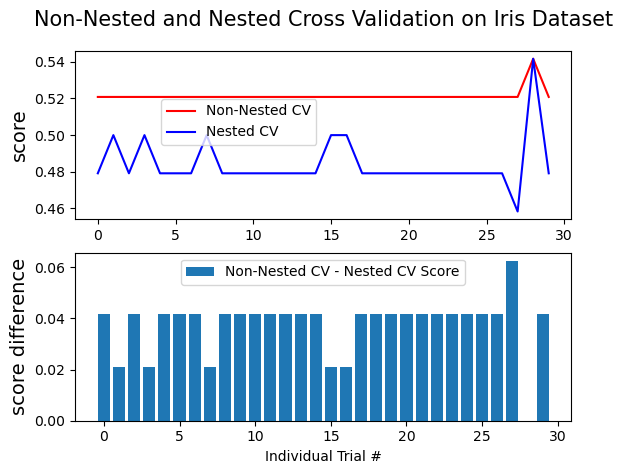

In [14]:
# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(non_nested_scores_line,) = plt.plot(non_nested_scores, color="r")
(nested_line,) = plt.plot(nested_scores, color="b")
plt.ylabel("score", fontsize="14")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Non-Nested and Nested Cross Validation on Iris Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1, 0.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()